In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from einops import rearrange

class vgg19_finetune(nn.Module):
    def __init__(self, num_emotions) -> None:
        super().__init__()
        
        self.model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
        self.model_ft = nn.Sequential(*(list(self.model_ft.children())[:-1]))
        
        for name, param in self.model_ft[0][:19].named_parameters():
            param.requires_grad=False
        
        self.fc_linear = nn.Linear(25088, 8)
        
        self.softmax_out = nn.Softmax(dim=1)
    
    def forward(self, x):
        
        output = self.model_ft(x)
        output = torch.flatten(output, start_dim=1)
        output_logits = self.fc_linear(output)
        output_softmax = self.softmax_out(output_logits)
        
        return output_logits, output_softmax

In [2]:
import os
import torch
import numpy as np
from torchinfo import summary
from tqdm.auto import tqdm

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

emotions_dict = {
    0: 'Neutral',
    1: 'Calm',
    2: 'Happy',
    3: 'Sad',
    4: 'Angry',
    5: 'Fear',
    6: 'Disgust',
    7: 'Surprise'
}

model = vgg19_finetune(num_emotions=len(emotions_dict)).to('cuda')
sub_name = 'vgg19_finetune'
data_name = 'RAVDESS'
EARLY_CNT = 500

minibatch = 128
num_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)

print(summary(model, input_size=(minibatch, 3, 224, 224)))

Using cache found in C:\Users\devLupin/.cache\torch\hub\pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
vgg19_finetune                           [128, 8]                  --
├─Sequential: 1-1                        [128, 512, 7, 7]          --
│    └─Sequential: 2-1                   [128, 512, 7, 7]          --
│    │    └─Conv2d: 3-1                  [128, 64, 224, 224]       (1,792)
│    │    └─ReLU: 3-2                    [128, 64, 224, 224]       --
│    │    └─Conv2d: 3-3                  [128, 64, 224, 224]       (36,928)
│    │    └─ReLU: 3-4                    [128, 64, 224, 224]       --
│    │    └─MaxPool2d: 3-5               [128, 64, 112, 112]       --
│    │    └─Conv2d: 3-6                  [128, 128, 112, 112]      (73,856)
│    │    └─ReLU: 3-7                    [128, 128, 112, 112]      --
│    │    └─Conv2d: 3-8                  [128, 128, 112, 112]      (147,584)
│    │    └─ReLU: 3-9                    [128, 128, 112, 112]      --
│    │    └─MaxPool2d: 3-10              [128, 128, 56, 56]  

In [3]:
def make_train_step(model, criterion, optimizer):

    # define the training step of the training phase
    def train_step(X, Y):

        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax, dim=1)
        accuracy = torch.sum(Y == predictions)/float(len(Y))

        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y)

        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad()

        return loss.item(), accuracy*100
    return train_step

In [4]:
def make_validate_fnc(model, criterion):
    def validate(X, Y):

        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase:
        with torch.no_grad():

            # set model to validation phase i.e. turn off dropout and batchnorm layers
            model.eval()
            
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax, dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y == predictions)/float(len(Y))

            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits, Y)

        return loss.item(), accuracy*100, predictions
    return validate

In [5]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [6]:
def criterion(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

In [7]:
from einops import rearrange

def train(model, num_epochs, X_train, Y_train, X_valid, Y_valid, pkl_name, fold):
    
    # instantiate lists to hold scalar performance metrics to plot later
    train_losses = []
    valid_losses = []

    # get training set size to calculate # iterations and minibatch indices
    train_size = X_train.shape[0]

    # instantiate the checkpoint save function
    save_checkpoint = make_save_checkpoint()

    # instantiate the training step function
    train_step = make_train_step(model, criterion, optimizer=optimizer)
    # instantiate the validation loop function
    validate = make_validate_fnc(model, criterion)

    cur_valid_loss = 0x3f3f3f
    early_stop_cnt = 0
    
    for epoch in tqdm(range(num_epochs), desc=f'{fold}'):

        if early_stop_cnt >= EARLY_CNT:
            break
        
        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)

        # shuffle the training set for each epoch:
        X_train = X_train[train_indices, :, :, :]
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate
        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start

            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end, :, :, :]
            # get training minibatch labels
            Y = Y_train[batch_start:batch_end]
            
            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            X_tensor = X_tensor.permute(0, 3, 1, 2)
            Y_tensor = torch.tensor(Y, dtype=torch.long, device=device)
            
            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor, Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}', end='')

        X_valid_tensor = torch.tensor(X_valid, device=device).float()
        X_valid_tensor = X_valid_tensor.permute(0, 3, 1, 2)
        Y_valid_tensor = torch.tensor(Y_valid, dtype=torch.long, device=device)
        
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor, Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        
        if cur_valid_loss > valid_loss:
            save_checkpoint(optimizer, model, epoch, pkl_name)
            cur_valid_loss = valid_loss
        else:
            early_stop_cnt += 1

        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')

        
    print(f"\n\n[*] done !")
    print(f'[*] Best training loss - {min(train_losses)}')
    print(f'[*] Best validation loss - {min(valid_losses)}')
    
    return train_losses, valid_losses

In [8]:
import csv
import cv2
import numpy as np
from PIL import Image
from skimage.io import imread
from skimage.transform import resize

def get_fold_dataset(cur_fold_path):
    X_train, y_train, X_test, y_test = [], [], [], []
    
    train_f = open(os.path.join(cur_fold_path, 'train.csv'), 'r')
    test_f = open(os.path.join(cur_fold_path, 'test.csv'), 'r')
    
    train_reader = csv.reader(train_f)
    for r in train_reader:
        image = imread(r[0])
        image = resize(image, (224,224,3))
        X_train.append(image)
        y_train.append(int(r[1]))
        
    test_reader = csv.reader(test_f)
    for r in test_reader:
        image = imread(r[0])
        image = resize(image, (224,224,3))
        X_test.append(image)
        y_test.append(int(r[1]))
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [9]:
all_fold_dataset = []

for fold in tqdm(range(5), desc='load melspectrogram fold dataset'):
    cur_fold_path = os.path.join('melspectrogram_fold', str(fold))
    X_train, y_train, X_test, y_test = get_fold_dataset(cur_fold_path)
    
    all_fold_dataset.append([X_train, y_train, X_test, y_test])

load melspectrogram fold dataset:   0%|          | 0/5 [00:00<?, ?it/s]

[*] model training - vgg19_finetune


0:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: iteration 7/8
Epoch 0 --- loss:1.885, Epoch accuracy:13.33%, Validation loss:2.096, Validation accuracy:11.00%
Epoch 1: iteration 7/8
Epoch 1 --- loss:1.875, Epoch accuracy:12.98%, Validation loss:2.085, Validation accuracy:11.00%
Epoch 2: iteration 7/8
Epoch 2 --- loss:1.862, Epoch accuracy:14.47%, Validation loss:2.076, Validation accuracy:12.00%
Epoch 3: iteration 7/8
Epoch 3 --- loss:1.853, Epoch accuracy:14.74%, Validation loss:2.067, Validation accuracy:13.00%
Epoch 4: iteration 7/8
Epoch 4 --- loss:1.843, Epoch accuracy:15.53%, Validation loss:2.059, Validation accuracy:14.00%
Epoch 5: iteration 7/8
Epoch 5 --- loss:1.835, Epoch accuracy:17.37%, Validation loss:2.052, Validation accuracy:16.00%
Epoch 6: iteration 7/8
Epoch 6 --- loss:1.823, Epoch accuracy:18.42%, Validation loss:2.045, Validation accuracy:18.67%
Epoch 7: iteration 7/8
Epoch 7 --- loss:1.817, Epoch accuracy:20.26%, Validation loss:2.038, Validation accuracy:20.33%
Epoch 8: iteration 7/8
Epoch 8 --- loss:

Epoch 68: iteration 7/8
Epoch 68 --- loss:0.595, Epoch accuracy:73.33%, Validation loss:1.356, Validation accuracy:49.67%
Epoch 69: iteration 7/8
Epoch 69 --- loss:0.580, Epoch accuracy:73.86%, Validation loss:1.363, Validation accuracy:50.00%
Epoch 70: iteration 7/8
Epoch 70 --- loss:0.572, Epoch accuracy:74.30%, Validation loss:1.357, Validation accuracy:49.00%
Epoch 71: iteration 7/8
Epoch 71 --- loss:0.540, Epoch accuracy:76.32%, Validation loss:1.358, Validation accuracy:49.67%
Epoch 72: iteration 7/8
Epoch 72 --- loss:0.531, Epoch accuracy:76.49%, Validation loss:1.347, Validation accuracy:49.67%
Epoch 73: iteration 7/8
Epoch 73 --- loss:0.516, Epoch accuracy:76.93%, Validation loss:1.352, Validation accuracy:50.00%
Epoch 74: iteration 7/8
Epoch 74 --- loss:0.501, Epoch accuracy:77.19%, Validation loss:1.354, Validation accuracy:51.00%
Epoch 75: iteration 7/8
Epoch 75 --- loss:0.490, Epoch accuracy:77.63%, Validation loss:1.360, Validation accuracy:51.00%
Epoch 76: iteration 7/8


Epoch 135: iteration 7/8
Epoch 135 --- loss:0.064, Epoch accuracy:89.82%, Validation loss:1.746, Validation accuracy:51.67%
Epoch 136: iteration 7/8
Epoch 136 --- loss:0.063, Epoch accuracy:89.82%, Validation loss:1.758, Validation accuracy:51.67%
Epoch 137: iteration 7/8
Epoch 137 --- loss:0.061, Epoch accuracy:89.82%, Validation loss:1.765, Validation accuracy:53.00%
Epoch 138: iteration 7/8
Epoch 138 --- loss:0.059, Epoch accuracy:89.82%, Validation loss:1.771, Validation accuracy:53.00%
Epoch 139: iteration 7/8
Epoch 139 --- loss:0.057, Epoch accuracy:89.82%, Validation loss:1.767, Validation accuracy:52.33%
Epoch 140: iteration 7/8
Epoch 140 --- loss:0.055, Epoch accuracy:89.82%, Validation loss:1.779, Validation accuracy:52.67%
Epoch 141: iteration 7/8
Epoch 141 --- loss:0.055, Epoch accuracy:89.82%, Validation loss:1.799, Validation accuracy:52.00%
Epoch 142: iteration 7/8
Epoch 142 --- loss:0.052, Epoch accuracy:89.82%, Validation loss:1.799, Validation accuracy:52.67%
Epoch 14

Epoch 201: iteration 7/8
Epoch 201 --- loss:0.015, Epoch accuracy:89.82%, Validation loss:2.095, Validation accuracy:52.67%
Epoch 202: iteration 7/8
Epoch 202 --- loss:0.014, Epoch accuracy:89.82%, Validation loss:2.097, Validation accuracy:52.67%
Epoch 203: iteration 7/8
Epoch 203 --- loss:0.014, Epoch accuracy:89.82%, Validation loss:2.104, Validation accuracy:52.67%
Epoch 204: iteration 7/8
Epoch 204 --- loss:0.014, Epoch accuracy:89.82%, Validation loss:2.114, Validation accuracy:52.67%
Epoch 205: iteration 7/8
Epoch 205 --- loss:0.014, Epoch accuracy:89.82%, Validation loss:2.119, Validation accuracy:52.33%
Epoch 206: iteration 7/8
Epoch 206 --- loss:0.013, Epoch accuracy:89.82%, Validation loss:2.123, Validation accuracy:52.33%
Epoch 207: iteration 7/8
Epoch 207 --- loss:0.013, Epoch accuracy:89.82%, Validation loss:2.117, Validation accuracy:52.67%
Epoch 208: iteration 7/8
Epoch 208 --- loss:0.013, Epoch accuracy:89.82%, Validation loss:2.121, Validation accuracy:52.67%
Epoch 20

Epoch 267: iteration 7/8
Epoch 267 --- loss:0.006, Epoch accuracy:89.82%, Validation loss:2.302, Validation accuracy:52.67%
Epoch 268: iteration 7/8
Epoch 268 --- loss:0.006, Epoch accuracy:89.82%, Validation loss:2.306, Validation accuracy:52.67%
Epoch 269: iteration 7/8
Epoch 269 --- loss:0.006, Epoch accuracy:89.82%, Validation loss:2.307, Validation accuracy:52.67%
Epoch 270: iteration 7/8
Epoch 270 --- loss:0.006, Epoch accuracy:89.82%, Validation loss:2.305, Validation accuracy:52.67%
Epoch 271: iteration 7/8
Epoch 271 --- loss:0.006, Epoch accuracy:89.82%, Validation loss:2.308, Validation accuracy:52.67%
Epoch 272: iteration 7/8
Epoch 272 --- loss:0.006, Epoch accuracy:89.82%, Validation loss:2.315, Validation accuracy:53.00%
Epoch 273: iteration 7/8
Epoch 273 --- loss:0.006, Epoch accuracy:89.82%, Validation loss:2.317, Validation accuracy:53.00%
Epoch 274: iteration 7/8
Epoch 274 --- loss:0.006, Epoch accuracy:89.82%, Validation loss:2.321, Validation accuracy:53.00%
Epoch 27

Epoch 333: iteration 7/8
Epoch 333 --- loss:0.004, Epoch accuracy:89.82%, Validation loss:2.437, Validation accuracy:53.00%
Epoch 334: iteration 7/8
Epoch 334 --- loss:0.004, Epoch accuracy:89.82%, Validation loss:2.436, Validation accuracy:53.00%
Epoch 335: iteration 7/8
Epoch 335 --- loss:0.004, Epoch accuracy:89.82%, Validation loss:2.437, Validation accuracy:53.00%
Epoch 336: iteration 7/8
Epoch 336 --- loss:0.004, Epoch accuracy:89.82%, Validation loss:2.437, Validation accuracy:53.00%
Epoch 337: iteration 7/8
Epoch 337 --- loss:0.004, Epoch accuracy:89.82%, Validation loss:2.438, Validation accuracy:53.00%
Epoch 338: iteration 7/8
Epoch 338 --- loss:0.003, Epoch accuracy:89.82%, Validation loss:2.441, Validation accuracy:53.00%
Epoch 339: iteration 7/8
Epoch 339 --- loss:0.003, Epoch accuracy:89.82%, Validation loss:2.445, Validation accuracy:53.00%
Epoch 340: iteration 7/8
Epoch 340 --- loss:0.003, Epoch accuracy:89.82%, Validation loss:2.446, Validation accuracy:53.00%
Epoch 34

Epoch 399: iteration 7/8
Epoch 399 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.538, Validation accuracy:53.00%
Epoch 400: iteration 7/8
Epoch 400 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.542, Validation accuracy:53.00%
Epoch 401: iteration 7/8
Epoch 401 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.544, Validation accuracy:53.00%
Epoch 402: iteration 7/8
Epoch 402 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.543, Validation accuracy:53.00%
Epoch 403: iteration 7/8
Epoch 403 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.544, Validation accuracy:53.00%
Epoch 404: iteration 7/8
Epoch 404 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.545, Validation accuracy:53.00%
Epoch 405: iteration 7/8
Epoch 405 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.545, Validation accuracy:53.00%
Epoch 406: iteration 7/8
Epoch 406 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.542, Validation accuracy:53.00%
Epoch 40

Epoch 465: iteration 7/8
Epoch 465 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.626, Validation accuracy:53.00%
Epoch 466: iteration 7/8
Epoch 466 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.626, Validation accuracy:53.00%
Epoch 467: iteration 7/8
Epoch 467 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.626, Validation accuracy:53.00%
Epoch 468: iteration 7/8
Epoch 468 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.626, Validation accuracy:53.00%
Epoch 469: iteration 7/8
Epoch 469 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.626, Validation accuracy:53.00%
Epoch 470: iteration 7/8
Epoch 470 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.626, Validation accuracy:53.00%
Epoch 471: iteration 7/8
Epoch 471 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.626, Validation accuracy:53.00%
Epoch 472: iteration 7/8
Epoch 472 --- loss:0.002, Epoch accuracy:89.82%, Validation loss:2.627, Validation accuracy:53.00%
Epoch 47

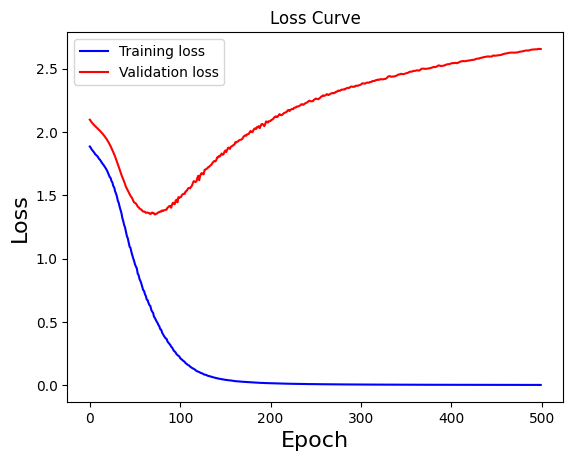

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

train_losses, valid_losses = [], []

print(f'[*] model training - {sub_name}')

fold_path = 'melspectrogram_fold'

for fold in range(5):
    cur = all_fold_dataset[fold]
    
    
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    train_losses, valid_losses = train(model, num_epochs, cur[0], cur[1], cur[2], cur[3], pkl_name, fold)
    
    plt.title('Loss Curve')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(train_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])
    plt.show()
    break

[*] 0 Test accuracy is 49.67%


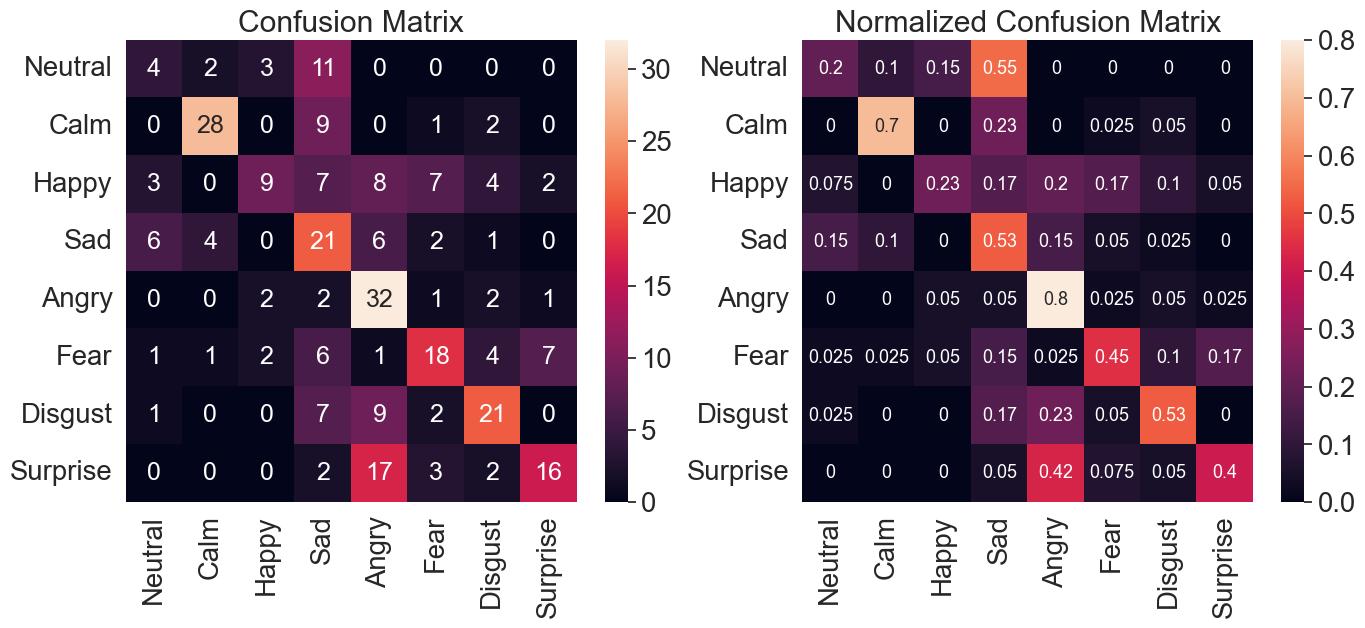

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

device = torch.device('cpu')
model = model.to(device)

test_accs = []

for fold in range(5):
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    
    load_checkpoint(optimizer, model, pkl_name)
    
    validate = make_validate_fnc(model, criterion)
    
    cur = all_fold_dataset[fold]
    
    X_test_tensor = torch.tensor(cur[2]).float()
    X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(cur[3], dtype=torch.long)
    
    test_loss, test_acc, predicted_emotions = validate(X_test_tensor, y_test_tensor)
    print(f'[*] {fold} Test accuracy is {test_acc:.2f}%')
    test_accs.append(test_acc)
    
    predicted_emotions = predicted_emotions.cpu().numpy()
    # use labels from test set
    emotions_groundtruth = y_test_tensor

    # build confusion matrix and normalized confusion matrix
    conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
    conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

    # set labels for matrix axes from emotions
    emotion_names = [emotion for emotion in emotions_dict.values()]

    # make a confusion matrix with labels using a DataFrame
    confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
    confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

    # plot confusion matrices
    plt.figure(figsize=(16,6))
    sn.set(font_scale=1.8) # emotion label and title size
    plt.subplot(1,2,1)
    plt.title('Confusion Matrix')
    sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
    plt.subplot(1,2,2)
    plt.title('Normalized Confusion Matrix')
    sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

    plt.show()
    break

In [12]:
def Average(lst):
    return sum(lst) / len(lst)

print('[*] K-Fold training done !')
print(f'[*] Best fold acc : {max(test_accs):.2f}%')
print(f'[*] Worst fold acc : {min(test_accs):.2f}%')
print(f'[*] Average fold acc : {Average(test_accs):.2f}%')

[*] K-Fold training done !
[*] Best fold acc : 49.67%
[*] Worst fold acc : 49.67%
[*] Average fold acc : 49.67%


In [13]:
from sklearn.metrics import classification_report

device = torch.device('cpu')
model = model.to(device)

test_accs = []

for fold in range(5):
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    
    load_checkpoint(optimizer, model, pkl_name)
    
    validate = make_validate_fnc(model, criterion)
    
    cur = all_fold_dataset[fold]
    
    X_test_tensor = torch.tensor(cur[2]).float()
    X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(cur[3], dtype=torch.long)
    
    test_loss, test_acc, predicted_emotions = validate(X_test_tensor, y_test_tensor)
    print(f'[*] {fold} Test accuracy is {test_acc:.2f}%')
    test_accs.append(test_acc)
    
    predicted_emotions = predicted_emotions.cpu().numpy()
    # use labels from test set
    emotions_groundtruth = y_test_tensor

    print(classification_report(emotions_groundtruth, predicted_emotions))
    break

[*] 0 Test accuracy is 49.67%
              precision    recall  f1-score   support

           0       0.27      0.20      0.23        20
           1       0.80      0.70      0.75        40
           2       0.56      0.23      0.32        40
           3       0.32      0.53      0.40        40
           4       0.44      0.80      0.57        40
           5       0.53      0.45      0.49        40
           6       0.58      0.53      0.55        40
           7       0.62      0.40      0.48        40

    accuracy                           0.50       300
   macro avg       0.51      0.48      0.47       300
weighted avg       0.53      0.50      0.49       300

